# Prepare bigquery database with Crystallographic Open Database (COD) data

## 1. Download and extract .cif files from COD .zip file

In [ ]:
# download COD database and extract .cif files into 'cifs' directory
!wget http://www.crystallography.net/archives/cod-cifs-mysql.zip .
%rm -rf mysql
!unzip cod-cifs-mysql.zip > /dev/null
!mkdir cifs
%cd cif/
!find . -name '*.cif' -exec mv {} ../cifs \;
%cd ..
%rm -rf cif
%rm cod-cifs-mysql.zip

## 2. Check uniqueness of .cif files

In [4]:
# populate a .csv file with the .cif filenames
!touch cifnames.csv
%cd cifs
!ls > ../cifnames.csv
%cd ..

/home/trev/repos/materials-discovery/cifs


In [350]:
import pandas as pd

cifs = pd.read_csv('cifnames.csv', header=None)
cifs.rename(columns={0: 'filename'}, inplace=True)
cifs['filename'] = cifs['filename'].apply(lambda x: pd.NA if '.cif' not in x else x)

In [351]:
cifs

,filename
0,1000000.cif
1,1000001.cif
2,1000002.cif
3,1000003.cif
4,1000004.cif
...,...
501204,9017916.cif
501205,9017917.cif
501206,9017918.cif
501207,9017919.cif


In [155]:
cifs['filename'].nunique()

501209

The number of unique .cif filenames equals the length of the dataframe, so all the files are unique.

## 3. Create dataframe containing data on how often each element occurs in the database

This section extracts the number of times each element occurs in each .cif file. It does not count their relative proportions as per the chemical formulae; it just assigns a 1 for "yes, this .cif file contains hydrogen", or 0 for no, etc. The reason for this is to restrict the range of atomic numbers to ensure that the input space is not too sparse.

NOTE: The entire set of 500,000 or so .cif files takes about 5 hours to process when parallelised across 16 cores. Approach with patience. (Or improve my code :) )

In [213]:
elements = {1:"H",2:"He",3:"Li",4:"Be",5:"B",6:"C",7:"N",8:"O",9:"F",10:"Ne",
11:"Na",12:"Mg",13:"Al",14:"Si",15:"P",16:"S",17:"Cl",18:"Ar",19:"K",20:"Ca",
21:"Sc",22:"Ti",23:"V",24:"Cr",25:"Mn",26:"Fe",27:"Co",28:"Ni",29:"Cu",30:"Zn",
31:"Ga",32:"Ge",33:"As",34:"Se",35:"Br",36:"Kr",37:"Rb",38:"Sr",39:"Y",40:"Zr",
41:"Nb",42:"Mo",43:"Tc",44:"Ru",45:"Rh",46:"Pd",47:"Ag",48:"Cd",49:"In",50:"Sn",
51:"Sb",52:"Te",53:"I",54:"Xe",55:"Cs",56:"Ba",57:"La",58:"Ce",59:"Pr",60:"Nd",
61:"Pm",62:"Sm",63:"Eu",64:"Gd",65:"Tb",66:"Dy",67:"Ho",68:"Er",69:"Tm",70:"Yb",
71:"Lu",72:"Hf",73:"Ta",74:"W",75:"Re",76:"Os",77:"Ir",78:"Pt",79:"Au",80:"Hg",
81:"Tl",82:"Pb",83:"Bi",84:"Po",85:"At",86:"Rn",87:"Fr",88:"Ra",89:"Ac",90:"Th",
91:"Pa",92:"U",93:"Np",94:"Pu",95:"Am",96:"Cm",97:"Bk",98:"Cf",99:"Es",100:"Fm",
101:"Md",102:"No",103:"Lr",104:"Rf",105:"Db",106:"Sg",107:"Bh",108:"Hs",109:"Mt",
110:"Ds",111:"Rg",112:"Cn",113:"Nh",114:"Fl",115:"Mc",116:"Lv",117:"Ts",118:"Og",
}

filenames = os.listdir('cifs')

In [259]:
# dataframe with atomic numbers 0 to 118 as columns; .cif filenames as index
df = pd.DataFrame(0, columns=elements.keys(), index=filenames)

In [315]:
import os
import numpy as np
from ase.io import read
from multiprocessing import Pool, cpu_count

pd.set_option('display.max_columns', None)

def process_file(filename, directory):
    
    """
    Reads a .cif file in a specified directory and returns a tuple with
    filename and a dict of length 118 (the maximum atomic number considered)
    where the keys are the atomic number and the values are 1 or 0 depending
    on whether the elements with that atomic number occur in the file.

    e.g. for a .cif containing only H and Li, the return value is:
    
    ('my_LiH_cif_file.cif', {1:1, 2:0, 3:1, 4:0, 5:0, 6:0, ... , 118:0})
    
    """
    
    vec = np.zeros(len(elements))
    try:
        atoms = read(f'{directory}/{filename}')
        atomic_numbers = list(set(atoms.get_atomic_numbers()))
        row = dict.fromkeys(range(1, 119), 0)
        for num in atomic_numbers:
            row[num] = 1
        return (filename, row)
    except Exception as e:
        os.remove(f'{directory}/{filename}')        
        return (filename, None)
        print(f'File {filename} failed: {e}')

filenames = os.listdir('cifs')

# create a multiprocessing pool
pool = Pool(cpu_count())

# process files in parallel
results = pool.map(process_file, filenames)

# close the pool and wait for all processes to finish
pool.close()
pool.join()

# filter out unsuccessful results and create dataframe with filenames as
# index and columns as atomic number
successful_results = [result for result in results if result[1] is not None]
indices = [result[0] for result in successful_results]
data = [result[1] for result in successful_results]
df = pd.DataFrame(data, index=indices)

df.to_csv('counts.csv', index=False)

The dataframe below has the atomic number in the columns, and the .cif file name in the rows.

In [330]:
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118
7202035.cif,1,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4318965.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2238511.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7121865.cif,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007483.cif,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007991.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005370.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8102810.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7243130.cif,1,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# drop the 3 strange occurrences of atomic number 0 
df = df.drop(0, axis=1)

In [326]:
df.sum(axis=0)

1      424813
2          14
3        7876
4         841
5       37093
        ...  
114         2
115         0
116         0
117         0
118         0
Length: 118, dtype: int64

## 4. Visualise the data

The barchart shows how often each element appears in the .cif files from the COD database. 

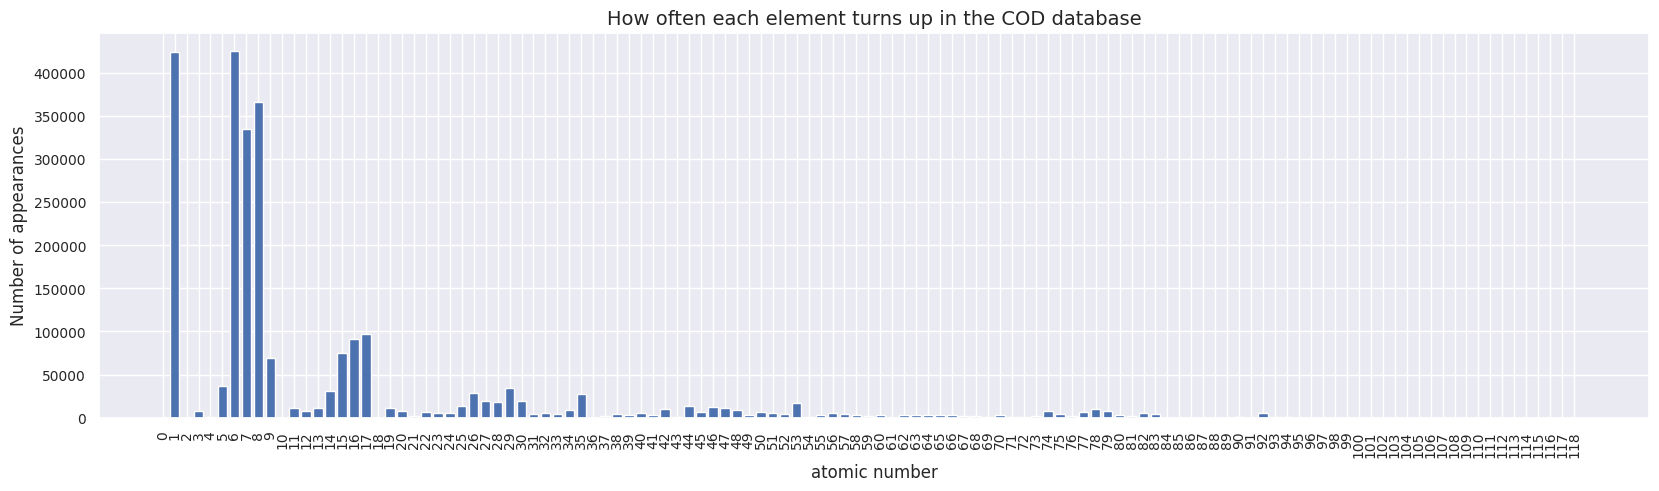

In [346]:
# Plot the barchart 
barchart = plt.figure(figsize=(20,5))
ax = barchart.add_subplot(111)
ax.bar(df.sum(axis=0).index, df.sum(axis=0).values)
ax.set_title('How often each element turns up in the COD database', fontsize=14)
ax.set_xlabel('atomic number', fontsize=12)
ax.set_ylabel('Number of appearances', fontsize=12)
ax.tick_params(axis='both', which='major',labelsize=10)
plt.xticks(np.arange(0,119,1), rotation='vertical')
plt.show()

Since not much above Z=84 turns up, drop those columns: (Sorry, Uranium.)

In [ ]:
df = df.drop(np.arange(84, 118, 1), axis=1)

Let's plot the correlation matrix to see which elements tend to occur together:

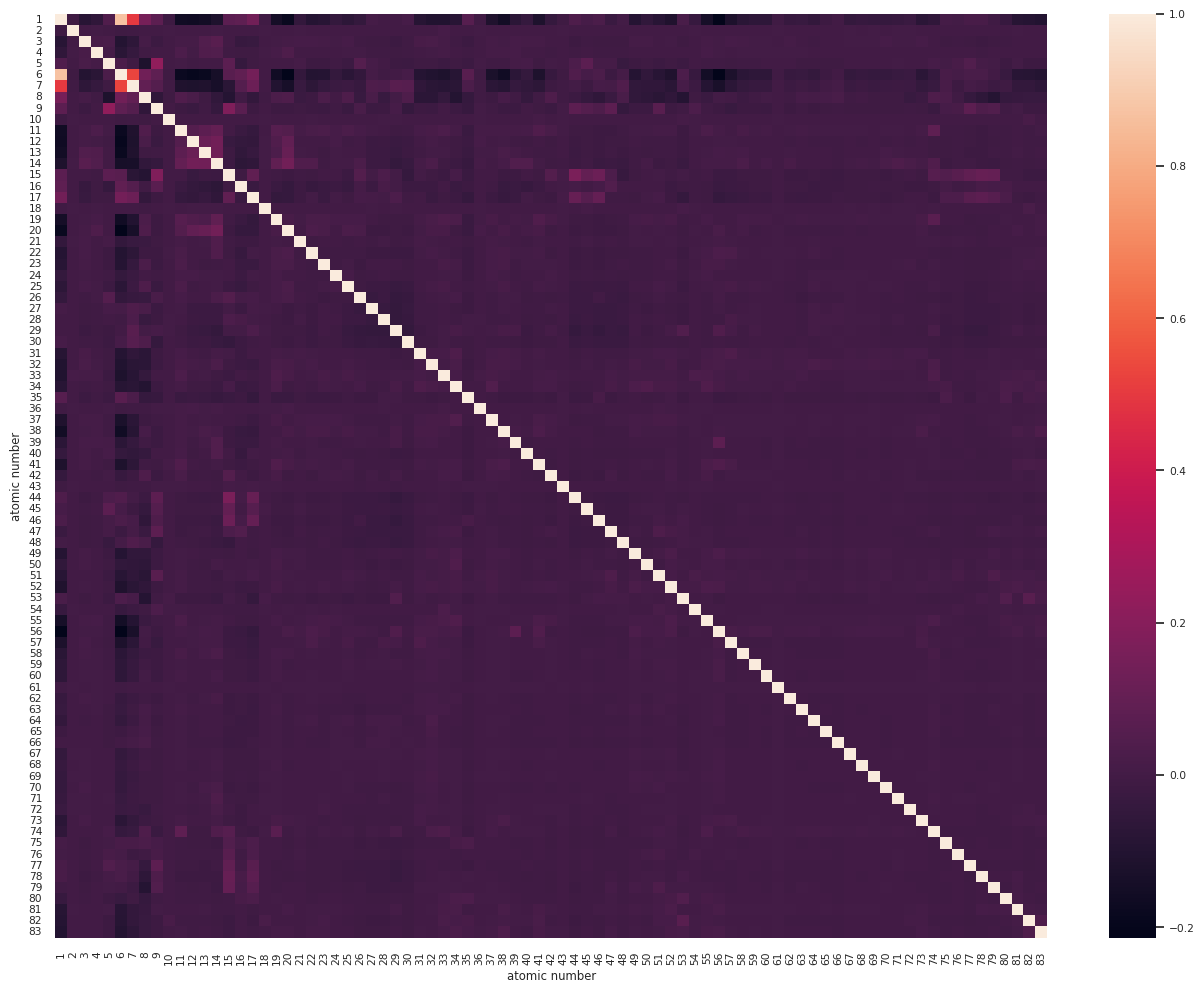

In [388]:
import matplotlib.pyplot as plt
import seaborn as sns

corr_matrix = df.corr()

sns.set(font_scale=0.7)
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix)
plt.ylabel('atomic number')
plt.xlabel('atomic number')
plt.show()